Loading file: C:\Users\abhin\Downloads\amazonreviews (1).tsv
Shape: (10000, 2)


,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,"""Amazing!: This soundtrack is my favorite musi..."
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


Columns: ['label', 'review']
Using text column: review
Using label column: label

Example cleaned text (first row):
stuning even non gamer sound track beautiful paint senery mind well would recomend even people hate vid game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen
Label column used: label   Unique labels (sample): ['pos' 'neg']
Detected # classes: 2
Label encoder classes: ['neg', 'pos']
Train/test sizes: 8000 2000

Training pipeline (TF-IDF + Logistic Regression)...

Accuracy: 0.851

Classification report:
              precision    recall  f1-score   support

         neg       0.85      0.85      0.85      1019
         pos       0.85      0.85      0.85       981

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Confusion matrix:
 [[869 150]
 [

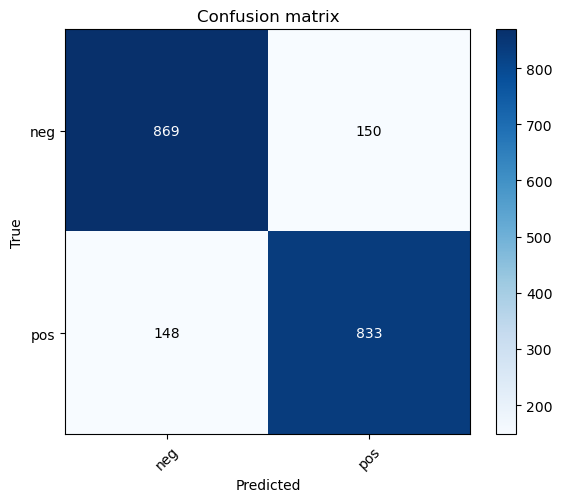

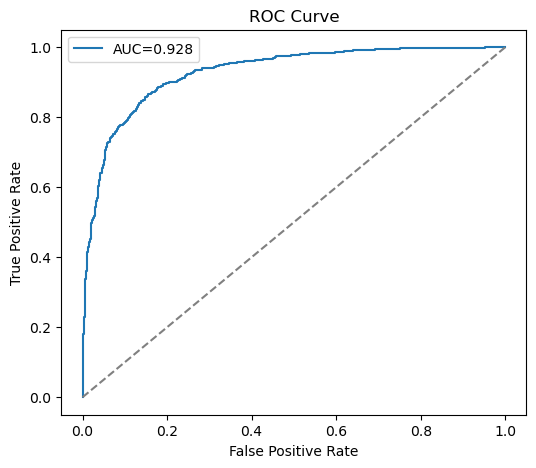


Top positive features: ['great', 'love', 'excellent', 'best', 'perfect', 'good', 'well', 'easy', 'amazing', 'wonderful', 'must', 'favorite', 'awesome', 'loved', 'highly']
Top negative features: ['boring', 'bad', 'waste', 'disappointed', 'poor', 'worst', 'money', 'disappointing', 'horrible', 'nothing', 'terrible', 'would', 'return', 'waste money', 'disappointment']

Saved pipeline and label encoder to: C:\Users\abhin\nlp_outputs

Exporting predictions for the full dataset...
Saved predictions to: C:\Users\abhin\nlp_outputs\amazonreviews_predictions.csv

Demo predictions:


,text,predicted_label,top_prob
0,This product is amazing and works perfectly!,pos,0.858498
1,Worst purchase ever. Broke in two days.,neg,0.862058



ALL DONE. All outputs (models, predictions) are in: C:\Users\abhin\nlp_outputs


In [1]:
# ===== NLP pipeline =====================
# Paste this whole cell into Jupyter and run.
import warnings
warnings.filterwarnings("ignore")

# Standard libs
from pathlib import Path
import re, os, joblib
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# ensure NLTK resources
for pkg in ("wordnet","stopwords","punkt","vader_lexicon"):
    try:
        nltk.data.find(f"corpora/{pkg}")
    except Exception:
        try:
            nltk.download(pkg, quiet=True)
        except Exception:
            pass

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
sia = SentimentIntensityAnalyzer()

# ---------------- CONFIG ----------------
# Try common paths (adjust if needed)
paths_to_try = [
    r"C:\Users\abhin\Downloads\amazonreviews (1).tsv",
    r"C:\Users\abhin\Downloads\amazonreviews.tsv",
    r"/mnt/data/amazonreviews (1).tsv",
    r"/mnt/data/amazonreviews.tsv",
    "amazonreviews (1).tsv",
    "amazonreviews.tsv"
]
csv_path = None
for p in paths_to_try:
    if Path(p).exists():
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError("Could not find amazonreviews TSV. Put file in Downloads or notebook folder, or update paths_to_try.")

out_dir = Path(r"C:\Users\abhin\nlp_outputs") if Path(r"C:\Users\abhin").exists() else Path("./nlp_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

print("Loading file:", csv_path)
# try reading as TSV
df = pd.read_csv(csv_path, sep="\t", quoting=3, encoding='utf-8', on_bad_lines='skip')
print("Shape:", df.shape)
display(df.head())
print("Columns:", list(df.columns))

# ---------------- identify columns ----------------
# Find text column
text_candidates = [c for c in df.columns if any(k in c.lower() for k in ("review","text","comment","body"))]
if not text_candidates:
    # fallback to longest-average-string column
    avglen = {c: df[c].astype(str).map(len).mean() for c in df.columns}
    cand = max(avglen, key=avglen.get)
    text_col = cand
else:
    text_col = text_candidates[0]
print("Using text column:", text_col)

# Find label column
label_candidates = [c for c in df.columns if any(k in c.lower() for k in ("label","sentiment","sent","rating","score","stars"))]
label_col = label_candidates[0] if label_candidates else None
if label_col:
    print("Using label column:", label_col)
else:
    raise ValueError("No label/rating column detected. Pipeline expects a label column like 'label' or 'rating'.")

# ---------------- text cleaning ----------------
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).lower()
    s = re.sub(r"<.*?>", " ", s)
    s = re.sub(r"http\S+|www\S+|https\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    tokens = nltk.word_tokenize(s)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1 and not t.isdigit()]
    lem = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lem)

# quick sanity example
print("\nExample cleaned text (first row):")
print(clean_text(df[text_col].iloc[0]))

# ---------------- prepare supervised labels ----------------
# If rating numeric -> derive binary positive/negative (>=4 pos, <=2 neg), else use categorical label column directly
df_work = df.copy()
label_col_use = label_col

# try detect numeric ratings
is_numeric = False
try:
    _ = pd.to_numeric(df_work[label_col].dropna().iloc[:5])
    is_numeric = True
except Exception:
    is_numeric = False

if is_numeric and str(df_work[label_col].dtype) not in ("object", "string"):
    print("Numeric rating detected — deriving binary labels (>=4 positive, <=2 negative); dropping neutral)")
    ratings = pd.to_numeric(df_work[label_col], errors='coerce')
    df_work['derived_label'] = np.nan
    df_work.loc[ratings >= 4, 'derived_label'] = "pos"
    df_work.loc[ratings <= 2, 'derived_label'] = "neg"
    df_work = df_work.dropna(subset=['derived_label', text_col])
    label_col_use = 'derived_label'
else:
    # normalize textual labels to simple pos/neg if applicable
    df_work = df_work.dropna(subset=[label_col, text_col])
    # common label maps
    df_work[label_col] = df_work[label_col].astype(str).str.strip().str.lower()
    # map common words
    mapping = {}
    for val in df_work[label_col].unique():
        if any(k in val for k in ("pos","positive","good","awesome","great")):
            mapping[val] = "pos"
        elif any(k in val for k in ("neg","negative","bad","poor","terrible","worst")):
            mapping[val] = "neg"
    if mapping:
        df_work[label_col] = df_work[label_col].map(lambda v: mapping.get(v, v))
    label_col_use = label_col

print("Label column used:", label_col_use, "  Unique labels (sample):", pd.Series(df_work[label_col_use]).unique()[:10])

# If multi-class, we still proceed; if too many classes, warn
num_classes_raw = df_work[label_col_use].nunique()
print("Detected # classes:", num_classes_raw)

# ---------------- create cleaned text column ----------------
df_work['clean_text'] = df_work[text_col].astype(str).map(clean_text)

# ---------------- create X,y and split ----------------
X = df_work['clean_text'].values
le = LabelEncoder()
y = le.fit_transform(df_work[label_col_use].astype(str).values)
print("Label encoder classes:", list(le.classes_))
if len(X) < 50:
    raise ValueError("Not enough labeled samples to train. Need more samples.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train/test sizes:", len(X_train), len(X_test))

# ---------------- pipeline: TF-IDF + LogisticRegression ----------------
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])

print("\nTraining pipeline (TF-IDF + Logistic Regression)...")
pipe.fit(X_train, y_train)

# ---------------- evaluate ----------------
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("\nAccuracy:", round(acc,4))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC for binary
if len(le.classes_) == 2:
    y_prob = pipe.predict_proba(X_test)[:,1]
    try:
        auc = roc_auc_score(y_test, y_prob)
        print("ROC AUC:", round(auc,4))
    except Exception:
        pass

# ---------------- plots: Confusion matrix & ROC ----------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

if len(le.classes_) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# ---------------- show top features (binary) ----------------
if len(le.classes_) == 2:
    vect = pipe.named_steps['tfidf']
    clf = pipe.named_steps['clf']
    feature_names = np.array(vect.get_feature_names_out())
    coefs = clf.coef_[0]
    top_pos = feature_names[np.argsort(coefs)[-20:]][::-1]
    top_neg = feature_names[np.argsort(coefs)[:20]]
    print("\nTop positive features:", list(top_pos[:15]))
    print("Top negative features:", list(top_neg[:15]))

# ---------------- save pipeline & encoder ----------------
joblib.dump(pipe, out_dir / "tfidf_logreg_pipeline.joblib")
joblib.dump(le, out_dir / "label_encoder.joblib")
print("\nSaved pipeline and label encoder to:", out_dir.resolve())

# ---------------- export predictions for whole dataset ----------------
print("\nExporting predictions for the full dataset...")
all_texts = df_work['clean_text'].fillna("").values
pred_enc_all = pipe.predict(all_texts)
pred_labels_all = le.inverse_transform(pred_enc_all)
probs_all = pipe.predict_proba(all_texts) if len(le.classes_)==2 else None
out_df = df_work.copy()
out_df['pred_label'] = pred_labels_all
if probs_all is not None:
    out_df['pred_prob_top'] = probs_all.max(axis=1)
out_csv = out_dir / "amazonreviews_predictions.csv"
out_df.to_csv(out_csv, index=False)
print("Saved predictions to:", out_csv.resolve())

# ---------------- utility: predict new texts ----------------
def predict_reviews(texts):
    """
    texts: list of raw review strings
    returns: DataFrame with text, predicted_label, top_prob (if binary)
    """
    texts_clean = [clean_text(t) for t in texts]
    enc = pipe.predict(texts_clean)
    labels = le.inverse_transform(enc)
    if len(le.classes_)==2:
        probs = pipe.predict_proba(texts_clean).max(axis=1)
        return pd.DataFrame({"text": texts, "predicted_label": labels, "top_prob": probs})
    else:
        return pd.DataFrame({"text": texts, "predicted_label": labels})

# show a small demo
demo = ["This product is amazing and works perfectly!", "Worst purchase ever. Broke in two days."]
print("\nDemo predictions:")
display(predict_reviews(demo))

print("\nALL DONE. All outputs (models, predictions) are in:", out_dir.resolve())
# =======================================================================================
